In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [2]:
from my_osm import get_osm_data
from my_isochrones import get_isochrones
from my_metrics import compute_edge_betweenness

In [3]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???
# Milano                               (Italy)              EPSG:6875 ???
# Ljubljana                            (Slovenia)           EPSG:8687 ???

place_name = 'Utrecht'
case_name = 'municipality'
local_crs = 'EPSG:28992'

In [5]:
buffer = 500

# Load data

In [6]:
# NL
if local_crs == 'EPSG:28992':
    place = gpd.read_file(os.path.join(output_folder, 'WijkBuurtkaart_2022_v0', 'SHP', 'CBS_buurten2022.shp'))
    
    if case_name == 'West':
        WK_NAAM = 'Wijk 01 West'
        BU_NAAM_exclude = 'Bedrijventerrein Lageweide'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM) & (place['BU_NAAM']!=BU_NAAM_exclude)]
        
    elif case_name == 'Zuid West':
        WK_NAAM = 'Wijk 08 Zuidwest'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM)]
    
    elif case_name == 'Zuid':
        WK_NAAM = 'Wijk 07 Zuid'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM)]
    
    elif case_name == 'three districts':
        BU_NAAM_exclude = 'Bedrijventerrein Lageweide'
        place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM'].isin(['Wijk 01 West', 'Wijk 08 Zuidwest', 'Wijk 07 Zuid'])) & (place['BU_NAAM']!=BU_NAAM_exclude)]

    elif case_name == 'municipality':
        place = place[(place['GM_NAAM']==place_name)]
        
# not NL
else:
    place = ox.geocode_to_gdf(place_name).to_crs(local_crs)

In [7]:
place = gpd.GeoDataFrame(index=[0], crs=local_crs, geometry=[place.unary_union])

<AxesSubplot:>

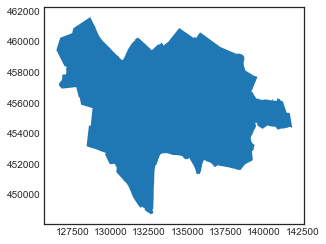

In [8]:
place.plot()

In [9]:
extent = place.buffer(buffer, join_style=2)
if len(extent) > 1:
    extent_shape = MultiPolygon([shape(part) for part in extent.to_crs('EPSG:4326')])     
else:
    extent_shape = extent.to_crs('EPSG:4326')[0]

### Barriers

#### roads, speed-based

In [10]:
# 50km/h
highway_speed_filter_50 = (f'["highway"]["maxspeed"~"50"]["tunnel"!="yes"]')
highway_speed_barrier_50 = gpd.clip(get_osm_data(highway_speed_filter_50, extent, 'convexhull'), extent)

In [11]:
# 60km/h and faster
highway_speed_filter_60more = (f'["highway"]["maxspeed"~"60|70|80|90|100|110|120|130"]["tunnel"!="yes"]')
highway_speed_barrier_60more = gpd.clip(get_osm_data(highway_speed_filter_60more, extent, 'convexhull'), extent)

#### roads, type-based

In [12]:
# major national roads
highway_type_filter_major = (f'["highway"~"motorway|motorway_link|trunk|trunk_link|escape|raceway"]["tunnel"!="yes"]')
highway_type_barrier_major = gpd.clip(get_osm_data(highway_type_filter_major, extent, 'convexhull'), extent)

In [13]:
# primary and secondary roads
highway_type_filter_12 = (f'["highway"~"primary|primary_link|secondary|secondary_link"]["tunnel"!="yes"]')
highway_type_barrier_12 = gpd.clip(get_osm_data(highway_type_filter_12, extent, 'convexhull'), extent)

In [14]:
# tertiary roads
highway_type_filter_3 = (f'["highway"~"tertiary|tertiary_link"]["tunnel"!="yes"]')
highway_type_barrier_3 = gpd.clip(get_osm_data(highway_type_filter_3, extent, 'convexhull'), extent)

Response <Response [429]>
Waiting 30sec, and trying again max 4 more times


In [15]:
# busways
highway_type_filter_bus = (f'["highway"~"busway|bus_guideway"]["tunnel"!="yes"]')
highway_type_barrier_bus = get_osm_data(highway_type_filter_bus, extent, 'convexhull')
if len(highway_type_barrier_bus):
    gpd.clip(highway_type_barrier_bus, extent)

#### rail, type-based

In [16]:
# tram
railway_filter_tram = (f'["railway"~"tram|light_rail"]["tunnel"!="yes"]')
railway_barrier_tram = gpd.clip(get_osm_data(railway_filter_tram, extent, 'convexhull'), extent)

In [17]:
# other rail
railway_filter_other = (f'["railway"]["railway"!~"^(razed|abandoned|disused|miniature|tram|light_rail)"]["tunnel"!="yes"]')
railway_barrier_other = gpd.clip(get_osm_data(railway_filter_other, extent, 'convexhull'), extent)

multiline member not handled {'type': 'way', 'ref': 487840867, 'role': '', 'geometry': [{'lat': 52.0900831, 'lon': 5.1089807}, {'lat': 52.0899273, 'lon': 5.1091264}, {'lat': 52.0898938, 'lon': 5.109033}, {'lat': 52.0900531, 'lon': 5.108897}, {'lat': 52.09026, 'lon': 5.1087262}, {'lat': 52.0905554, 'lon': 5.1085117}, {'lat': 52.0907736, 'lon': 5.1083677}, {'lat': 52.090775, 'lon': 5.1083739}, {'lat': 52.0908695, 'lon': 5.1083111}, {'lat': 52.0909563, 'lon': 5.108254}, {'lat': 52.0910399, 'lon': 5.1081983}, {'lat': 52.0910484, 'lon': 5.1082275}, {'lat': 52.0908558, 'lon': 5.108371}, {'lat': 52.090848, 'lon': 5.1083409}, {'lat': 52.090778, 'lon': 5.1083885}, {'lat': 52.0907819, 'lon': 5.1084036}, {'lat': 52.0907857, 'lon': 5.1084186}, {'lat': 52.0905702, 'lon': 5.108583}, {'lat': 52.0902852, 'lon': 5.1088029}, {'lat': 52.0902065, 'lon': 5.108871}, {'lat': 52.0901373, 'lon': 5.1089301}, {'lat': 52.0900831, 'lon': 5.1089807}]}
multiline member not handled {'type': 'way', 'ref': 450282166, '

#### natural, type-based

In [10]:
def greenspace_filter(gdf, local_crs,
                      threshold=0, place=None, min_area=None, max_area=None, G=None):
    """
    gdf = geoseries of greenery polygons (e.g. greenery.geometry)
    return = a union of filtered polygons
    [optional] threshold to merge spaces in proximity (in meters)
    [optional] place geoseries of total area geometries (e.g. place_gdf.geometry)
    [optional] minimum area for greenspace filter, default value set
    [optional] graph which greenspace should intersect nodes and edges of
    """
    
    filtered = gdf.copy()
    
    # only polygons, no points or lines
    filtered = filtered[(filtered.geom_type == 'Polygon')|(filtered.geom_type == 'MultiPolygon')]
    
    #union of adjacent and overlapping polygons
    filtered['geometry'] = filtered.buffer(threshold)
    filtered = gpd.GeoDataFrame(filtered.unary_union).rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(local_crs)
    filtered['geometry'] = filtered.buffer(-threshold)

    # filter on intersect with place
    if place is not None:
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(place.geometry), how="left", predicate='within')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
    # filter on minimum area
    if min_area is not None:
        filtered = filtered[filtered.geometry.area>=min_area]
        
    # filter on maximum area
    if max_area is not None:
        filtered = filtered[filtered.geometry.area<=max_area]
    
    # filter on intersection with network
    if G:
        edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(edges.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
        nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(nodes.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])

    filtered.drop_duplicates(inplace=True)
    return filtered

In [11]:
# blue
natural_filter_blue1 = (f'["natural"~"water"]')
natural_barrier_blue = gpd.clip(get_osm_data(natural_filter_blue1, extent, 'convexhull'), extent)

In [12]:
natural_filter_blue2 = '["waterway"~"^river|riverbank|stream|tidal_channel|canal|ditch|fairway"]["tunnel"!="yes"]'
natural_barrier_blue = natural_barrier_blue.append(get_osm_data(natural_filter_blue2, extent, 'convexhull'))

multiline member not handled {'type': 'way', 'ref': 881894224, 'role': '', 'geometry': [{'lat': 52.0821782, 'lon': 5.0802117}, {'lat': 52.0823379, 'lon': 5.0782247}, {'lat': 52.0823443, 'lon': 5.0781477}, {'lat': 52.0823874, 'lon': 5.077604}, {'lat': 52.082401, 'lon': 5.0773315}, {'lat': 52.0824187, 'lon': 5.0762294}, {'lat': 52.0824187, 'lon': 5.0756406}, {'lat': 52.0824113, 'lon': 5.0748185}, {'lat': 52.0824112, 'lon': 5.0743494}, {'lat': 52.0824104, 'lon': 5.0741869}, {'lat': 52.082417, 'lon': 5.0737416}, {'lat': 52.0824072, 'lon': 5.0727842}, {'lat': 52.0823923, 'lon': 5.0717632}, {'lat': 52.0823835, 'lon': 5.0708061}, {'lat': 52.0823567, 'lon': 5.0695459}, {'lat': 52.0823323, 'lon': 5.0692004}, {'lat': 52.0823341, 'lon': 5.0691379}, {'lat': 52.0823621, 'lon': 5.0681977}, {'lat': 52.0823813, 'lon': 5.0672232}, {'lat': 52.0823972, 'lon': 5.0662781}, {'lat': 52.0823797, 'lon': 5.0652902}, {'lat': 52.0823791, 'lon': 5.0644202}, {'lat': 52.0823786, 'lon': 5.0638024}, {'lat': 52.0823769

In [13]:
# pedestrian bridges
filter_ped_bridge=(f'["bridge"="yes"]["highway"~"^pedestrian|footway|living_street|track|bridleway|path"]["footway"!="sidewalk"]')
ped_bridge = get_osm_data(filter_ped_bridge, extent, 'convexhull')
ped_bridge_buffer = ped_bridge.buffer(25) 

In [14]:
# excluding pedestrian bridges from bluespace barriers
natural_barrier_blue_nopedbridge = gpd.GeoDataFrame(
    natural_barrier_blue.unary_union.difference(ped_bridge_buffer.unary_union)).rename(
    columns={0:'geometry'}).set_geometry('geometry').set_crs(local_crs)

In [14]:
# parks
natural_filter_parks = '["leisure"~"^(park)"]'
natural_barrier_parks = get_osm_data(natural_filter_parks, extent, 'convexhull')
tipping_point = 50000   
# anything between 25000 and 50000 works for Utrecht West
# for Zuid-West: from 30000 onwards? there is one around 35000 that I'm unsure about though
# for Zuid: ? above seems fine, intuitively, but not discussed during session
# setting on 50000 for now, clear barriers, keeping smaller up for discussion in Milan
natural_barrier_parks_large = gpd.clip(greenspace_filter(natural_barrier_parks, local_crs, min_area=tipping_point), extent)

In [15]:
# green, not parks
natural_filter_green1 = '["leisure"~"^(nature_reserve)"]'
natural_barrier_green = get_osm_data(natural_filter_green1, extent, 'convexhull')

In [16]:
natural_filter_green2 = '["landuse"~"^(forest|meadow|grass|village_green|allotments|flowerbed|farmland|farmyard|orchards|vineyard|plant_nursary)"]'
natural_barrier_green = natural_barrier_green.append(get_osm_data(natural_filter_green2, extent, 'convexhull'))

In [17]:
natural_filter_green3 = '["natural"~"^(wood|scrub|heath|grassland|fell|shrubbery)"]'
natural_barrier_green = natural_barrier_green.append(get_osm_data(natural_filter_green3, extent, 'convexhull'))

In [18]:
tipping_point = 50000   
# using same tipping point for other greenspaces, very very few larger than that
natural_barrier_green_large = gpd.clip(greenspace_filter(natural_barrier_green, local_crs, min_area=tipping_point), extent)

#### filter

In [15]:
def no_points(gdf):
    
    if len(gdf):
        filtered = gdf[(gdf.geom_type == 'Polygon')|(gdf.geom_type == 'MultiPolygon')|(gdf.geom_type == 'LineString')|(gdf.geom_type == 'MultiLineString')]
        return filtered
    else:
        return gdf

In [16]:
# highway_speed_barrier_50 = no_points(highway_speed_barrier_50)
# highway_speed_barrier_60more = no_points(highway_speed_barrier_60more)

# highway_type_barrier_major = no_points(highway_type_barrier_major)
# highway_type_barrier_12 = no_points(highway_type_barrier_12)
# highway_type_barrier_3 = no_points(highway_type_barrier_3)
# highway_type_barrier_bus = no_points(highway_type_barrier_bus)

# railway_barrier_tram = no_points(railway_barrier_tram)
# railway_barrier_other = no_points(railway_barrier_other)

natural_barrier_blue_nopedbridge = no_points(natural_barrier_blue_nopedbridge)
# natural_barrier_parks_large = no_points(natural_barrier_parks_large)
# natural_barrier_green_large = no_points(natural_barrier_green_large)

#### plots

/Users/roosteeuwen/opt/anaconda3/envs/child_greenspace_accessibility/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/roosteeuwen/opt/anaconda3/envs/child_greenspace_accessibility/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


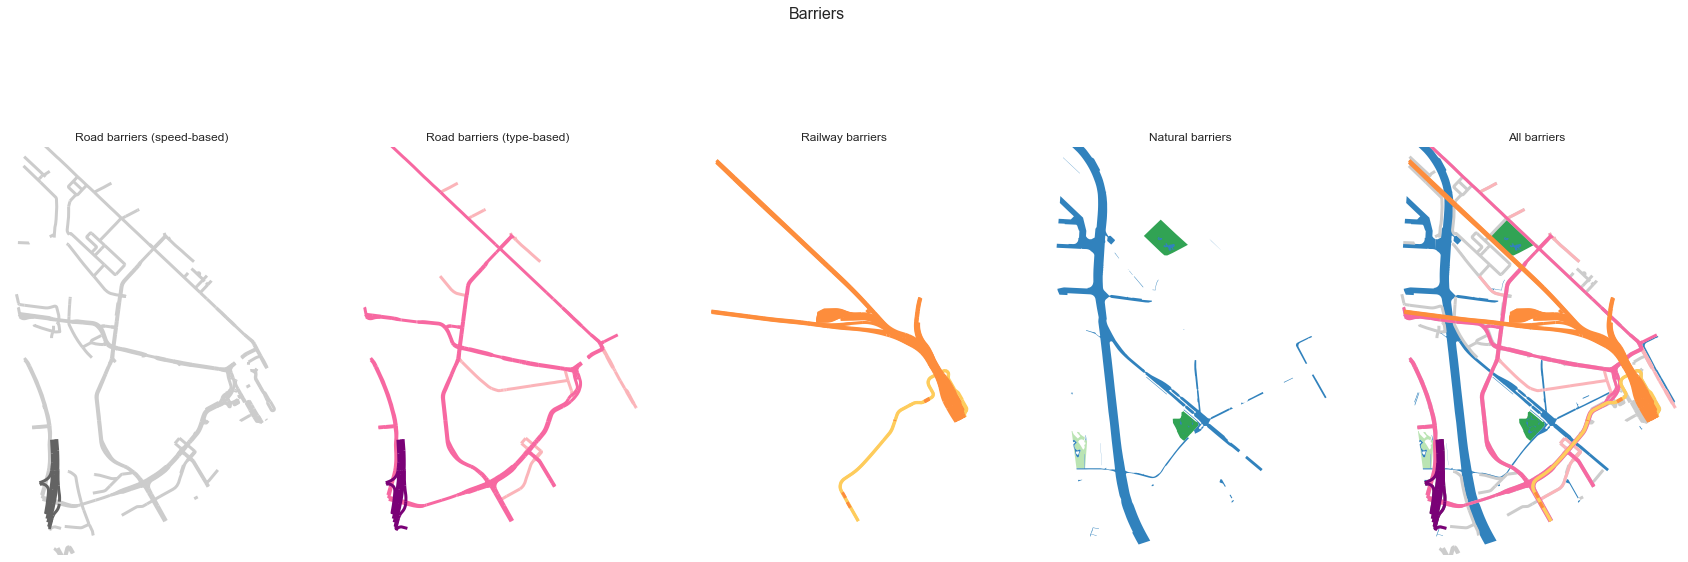

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,10))
fig.suptitle('Barriers', fontsize=16)


barrier_width = 3
    
# greys
highway_speed_barrier_50.plot(ax=axs[0], color='#cccccc', linewidth=barrier_width, zorder=1)
highway_speed_barrier_60more.plot(ax=axs[0], color='#636363', linewidth=barrier_width, zorder=2)
axs[0].set_title('Road barriers (speed-based)')

# pink-purple
highway_type_barrier_major.plot(ax=axs[1], color='#7a0177', linewidth=barrier_width, zorder=4)
highway_type_barrier_bus.plot(ax=axs[1], color='#c51b8a', linewidth=barrier_width, zorder=3)
highway_type_barrier_12.plot(ax=axs[1], color='#f768a1', linewidth=barrier_width, zorder=2)
highway_type_barrier_3.plot(ax=axs[1], color='#fbb4b9', linewidth=barrier_width, zorder=1)
axs[1].set_title('Road barriers (type-based)')

# orange
railway_barrier_tram.plot(ax=axs[2], color='#fecc5c', linewidth=barrier_width, zorder=1)
railway_barrier_other.plot(ax=axs[2], color='#fd8d3c', linewidth=barrier_width, zorder=2)
axs[2].set_title('Railway barriers')

# greenblue
natural_barrier_blue_nopedbridge.plot(ax=axs[3], color='#3182bd', linewidth=barrier_width, zorder=3)
natural_barrier_parks_large.plot(ax=axs[3], color='#31a354', linewidth=barrier_width, zorder=2)
natural_barrier_green_large.plot(ax=axs[3], color='#bae4b3', linewidth=barrier_width, zorder=1)
axs[3].set_title('Natural barriers')

# all combined
highway_speed_barrier_50.plot(ax=axs[4], color='#cccccc', linewidth=barrier_width, zorder=4)
highway_speed_barrier_60more.plot(ax=axs[4], color='#636363', linewidth=barrier_width, zorder=5)
highway_type_barrier_major.plot(ax=axs[4], color='#7a0177', linewidth=barrier_width, zorder=9)
highway_type_barrier_bus.plot(ax=axs[4], color='#c51b8a', linewidth=barrier_width, zorder=8)
highway_type_barrier_12.plot(ax=axs[4], color='#f768a1', linewidth=barrier_width, zorder=7)
highway_type_barrier_3.plot(ax=axs[4], color='#fbb4b9', linewidth=barrier_width, zorder=6)
railway_barrier_tram.plot(ax=axs[4], color='#fecc5c', linewidth=barrier_width, zorder=10)
railway_barrier_other.plot(ax=axs[4], color='#fd8d3c', linewidth=barrier_width, zorder=11)
natural_barrier_blue_nopedbridge.plot(ax=axs[4], color='#3182bd', linewidth=barrier_width, zorder=3)
natural_barrier_parks_large.plot(ax=axs[4], color='#31a354', linewidth=barrier_width, zorder=2)
natural_barrier_green_large.plot(ax=axs[4], color='#bae4b3', linewidth=barrier_width, zorder=1)
axs[4].set_title('All barriers')


for ax in axs:
    # place.plot(ax=ax, facecolor='none', edgecolor='yellow', linestyle='-', linewidth=1, zorder=1)
    
    bbox = place.total_bounds
    margin = 600
    xlim = ([bbox[0]-margin, bbox[2]+margin])
    ylim = ([bbox[1]-margin, bbox[3]+margin])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axis('off')

    
plt.show()

#  Store output data

In [17]:
place_name_out = (place_name + '_' + case_name).split(',')[0].replace(' ', '')
today = datetime.date.today().strftime("%d%b%Y")
output_sub_folder = os.path.join(output_folder, '{}_{}'.format(place_name_out, today))

In [18]:
output_sub_folder

'data/Utrecht_municipality_10Nov2022'

In [19]:
if not os.path.exists(output_sub_folder):
    os.mkdir(output_sub_folder)

In [33]:
output_file = os.path.join(output_sub_folder, 'highway_speed_barrier_50.geojson')
highway_speed_barrier_50_out = highway_speed_barrier_50.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_speed_barrier_50_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'highway_speed_barrier_60more.geojson')
highway_speed_barrier_60more_out = highway_speed_barrier_60more.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_speed_barrier_60more_out.to_file(output_file, driver='GeoJSON')

In [35]:
output_file = os.path.join(output_sub_folder, 'highway_type_barrier_major.geojson')
highway_type_barrier_major_out = highway_type_barrier_major.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_type_barrier_major_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'highway_type_barrier_bus.geojson')
highway_type_barrier_bus_out = highway_type_barrier_bus.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_type_barrier_bus_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'highway_type_barrier_12.geojson')
highway_type_barrier_12_out = highway_type_barrier_12.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_type_barrier_12_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'highway_type_barrier_3.geojson')
highway_type_barrier_3_out = highway_type_barrier_3.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_type_barrier_3_out.to_file(output_file, driver='GeoJSON')

In [36]:
output_file = os.path.join(output_sub_folder, 'railway_barrier_tram.geojson')
railway_barrier_tram_out = railway_barrier_tram.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
railway_barrier_tram_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'railway_barrier_other.geojson')
railway_barrier_other_out = railway_barrier_other.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
railway_barrier_other_out.to_file(output_file, driver='GeoJSON')

In [20]:
output_file = os.path.join(output_sub_folder, 'natural_barrier_blue_nopedbridge.geojson')
natural_barrier_blue_nopedbridge_out = natural_barrier_blue_nopedbridge.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
natural_barrier_blue_nopedbridge_out.to_file(output_file, driver='GeoJSON')

# output_file = os.path.join(output_sub_folder, 'natural_barrier_parks_large.geojson')
# natural_barrier_parks_large_out = natural_barrier_parks_large.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
# natural_barrier_parks_large_out.to_file(output_file, driver='GeoJSON')

# output_file = os.path.join(output_sub_folder, 'natural_barrier_green_large.geojson')
# natural_barrier_green_large_out = natural_barrier_green_large.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
# natural_barrier_green_large_out.to_file(output_file, driver='GeoJSON')